# Problem-NLP 文本情感分類

本題目目標是要實現一個人工智能模型，對文本消息進行識別，識別出其情感類型（比如悲傷、喜悅等）

**請注意，在第一部分的評分環節中，不要新增加刪除任何代碼塊，否則可能會導致賽後評分失敗**

**如果代碼塊有提示 `# 請不要修改此代碼塊` 則不可以進行任意修改**

無論是第一部分還是第二部分的評分，**請確保你的代碼可以在 Kaggle 選擇 T4 GPU 的情況下 15 分鐘內全部運行完畢**。

## 前置準備

以下代碼會加載評分器及進行前置準備，請不要修改

In [1]:
# 請不要修改此代碼塊

!cp /kaggle/input/moai-2025-nlp-task/grader.py .

import random

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

from grader import task_grader

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## 數據集

數據集中的每條記錄包含一個代表Twitter消息的文本片段，以及一個對應標籤用於標識該文本傳達的主要情感。

情感共分為六類：悲傷（0）、喜悦（1）、愛（2）、憤怒（3）、恐懼（4）和驚訝（5）。

以下代碼會讀取數據集並輸出

In [2]:
# 請不要修改此代碼塊

train_df = pd.read_csv("/kaggle/input/moai-2025-nlp-task/train.csv")
train_df

,id,text,label
0,0,i feel i can now return to university feeling ...,1
1,1,i will not embrace my sin and celebrate it mer...,2
2,2,im afraid to get close to anyone for fear of b...,3
3,3,i feel a strange comfort in complacency,5
4,4,i feel is the i want to make affectionate move...,2
...,...,...,...
59995,59995,i find it hard to talk to my partner on a visi...,3
59996,59996,i know and remember what a good day feels like...,5
59997,59997,i had been feeling stressed to the max with th...,3
59998,59998,i think of all the fears i mentioned about my ...,2


In [3]:
# 請不要修改此代碼塊

# 以下程式輸出數據集前 5 行查看
for i in range(5):
    print(train_df['label'][i], train_df['text'][i], sep=',  ')

1,  i feel i can now return to university feeling somewhat more content
2,  i will not embrace my sin and celebrate it merely so i can feel accepted and loved
3,  im afraid to get close to anyone for fear of being a supreme bitch to them when im feeling hateful and bitter
5,  i feel a strange comfort in complacency
2,  i feel is the i want to make affectionate movements as if i am in love


## 詞向量生成

本題目目標是要實現一個人工智能模型，該模型對一段文本消息進行識別，識別出其情感類型（比如悲傷、喜悅等），這可以視為一個分類模型（輸入文本，輸出情感分類）

實現這個模型的一個經典方法是使用詞向量，以下介紹什麼是詞向量

執行以下代碼後（需要一定時間下載模型），會輸出一個大小為 50 的數組，該數組表示 "hope" 單詞的詞向量。

代碼中的 `glove_model` 是一個詞表，詞表類似一個字典，可以查詢輸入單詞的詞向量，我們可以將原本對文字進行分類的問題轉換為對詞向量進行分類（這樣的效果更好）

In [4]:
# 請不要修改此代碼塊

glove_model = KeyedVectors.load_word2vec_format("/kaggle/input/moai-2025-nlp-task/glove-wiki-gigaword-50.txt")

print(glove_model['hope'])

[ 0.3336    0.74512   0.083166 -0.22648   0.52874  -0.33704  -0.54175
  0.81136   0.024572  0.37463  -0.057001  0.21685  -0.3829   -0.21458
  0.33302   0.64719   0.76588  -0.48044   0.33993  -0.41397  -0.05071
  0.50477  -0.11382  -0.48148   0.97721  -1.5711   -0.40916  -0.31893
  0.34678  -0.42318   2.8829    1.1383   -0.86361  -0.57353  -0.26611
 -0.5939   -0.25876  -0.081662  0.093148 -0.95213  -0.52034  -0.49373
 -0.12275  -0.39961   0.40267   0.56377  -0.17417   0.066513 -0.2793
 -0.06462 ]


## 第一部分評分（45 分）

以下是第一部分的題目，會引領你如何完成一個文本分類模型。

### 題目1：生成句子的詞向量

上面我們簡單地實現了生成一個單詞的詞向量，但是一個句子有很多個單詞，只使用一個單詞不能準確地判斷情感，因此我們可以使用更多單詞（比如 3 個）

**題目 1.1（5分）**: 本題的目標是編寫一個函數 `text_to_vec_v1` 該函數接收一個字符串 `text`，返回該句子的詞向量列表（一個 numpy array）。

比如 `text_to_vec_v1("I go to school by bus")` 應該返回長度為 6 的列表，每項都是一個詞向量（分別對應 `i`, `go`, `to`, `school`, `by`, `bus`），因此整體大小為 `6x50`

需要注意的是，`glove_model` 只能接收小寫英文，因此你在傳入之前應該進行處理。

提示：`np.zeros` 可以生成全部為 0 的 numpy array，比如 `np.zeros((20, 10))` 可以生 20x10 全為零的 numpy array。

**題目 1.2（5分）**：現在不同句子長度輸出的詞向量列表的大小是不同的比如 "i go to school by bus" 和 "i love you" 輸出分別為 `6x50` 和 `3x50`，但是神經網絡要求輸入大小要一樣，在本題中，你需要處理這種情況，編寫一個新的版本 `text_to_vec_v2` 函數，**使輸出大小都一致**。

提示：只取前 3 個單詞構成詞向量是一個可行的方法

**題目 1.3（5分）**：有時候有些單詞在 `glove_model` 中是不存在的，比如 ”asdvnalsdn”，使用 `glove_model["asdvnalsdn"]` 會報錯，修改 `text_to_vec_v2`，處理這個情況。

提示：對於字符串 X，可以使用 `if X in glove_model` 來判斷 X 是否在詞表中。

In [5]:
# 你可以在此代碼塊中 import 你所需要使用的第三方庫

In [6]:
def text_to_vec_v1(text):
    # TODO: 題目 1.1
    vec=text.split(" ")
    glove_model = KeyedVectors.load_word2vec_format("/kaggle/input/moai-2025-nlp-task/glove-wiki-gigaword-50.txt")
    listh=np.zeros((len(vec), 50))
    cnt=0
    for i in vec:
        i=i.lower()
        listt=glove_model[i]
        listh[cnt]=listt
        cnt+=1
    #print(listh)
    return np.array(listh)

In [7]:
vec = text_to_vec_v1("I go to school by bus")
print("Size：", vec.shape)

Size： (6, 50)


In [8]:
# 執行此代碼塊可以進行評分，請不要修改此代碼塊

task_grader.q1_1_check(text_to_vec_v1, glove_model)

Q1.1通過 (5分)


In [9]:
def text_to_vec_v2(text):
    # TODO: 題目 1.2
    vec=text.split(" ")
    glove_model = KeyedVectors.load_word2vec_format("/kaggle/input/moai-2025-nlp-task/glove-wiki-gigaword-50.txt")
    listh=np.zeros((3, 50))
    cnt=0
    for i in vec:
        i=i.lower()
        if i in glove_model:
            listt=glove_model[i]
            listh[cnt]=listt
            cnt+=1
            if cnt==3:break
    #print(listh)
    return np.array(listh)

In [10]:
vec = text_to_vec_v2("I love you")
print("Size：", vec.shape)

Size： (3, 50)


In [11]:
vec = text_to_vec_v2("I asdvnalsdn you")
print("Size：", vec.shape)

Size： (3, 50)


In [12]:
# 執行此代碼塊可以進行評分，請不要修改此代碼塊

task_grader.q1_2_check(text_to_vec_v2)
task_grader.q1_3_check(text_to_vec_v2)

Q1.2通過 (5分)
Q1.3通過 (5分)


### 題目 2：預處理及劃分數據集

**題目 2.1（3分）：** 利用 `text_to_vec_v2` 對原始數據中的英文文本進行預處理。

**題目 2.2（3分）：** 將 `embeddings` 和 `labels` 轉為 Tensor 並建立數據集，並按 8:2 的比例劃分為訓練集以及測試集。

**題目 2.3（3分）：** 隨後，使用 `DataLoader` 類創建一個 `train_loader` 以及 `val_loader` 對象，以供在訓練的時候加載數據到模型中。

In [97]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd

glove_model = KeyedVectors.load_word2vec_format("/kaggle/input/moai-2025-nlp-task/glove-wiki-gigaword-50.txt")
def text_to_vec_v2(text):
    # TODO: 題目 1.2
    vec=text.split(" ")    
    listh=np.zeros((3, 50))
    cnt=0
    for i in vec:
        i=i.lower()
        if i in glove_model:
            listt=glove_model[i]
            listh[cnt]=listt
            cnt+=1
            if cnt==3:break
    #print(listh)
    return np.array(listh)

listhh=np.zeros((60000,3, 50))
texts = train_df['text'].values
labels = train_df['label'].values
#print(texts)
# TODO: 將訓練集的全部文本用 `text_to_vec_v2` 轉為向量
for i in range(0,len(texts)):
    listhh[i]=text_to_vec_v2(texts[i])
    #print(new_text)
    #print(i)
embeddings=listhh
print("step1 end")
# TODO: 使用 embeddings 和 labels 建立數據集，並按 8:2 的比例劃分為訓練集以及測試集
labels = torch.tensor(train_df['label'].values)
num2=torch.tensor(embeddings)
dataset = TensorDataset(num2, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# TODO: 使用 DataLoader 類創建一個 train_loader 以及 val_loader 對象
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

step1 end


In [98]:
# 執行此代碼塊可以進行評分，請不要修改此代碼塊

task_grader.q2_1_check(embeddings, text_to_vec_v2, texts)
task_grader.q2_2_check(train_dataset, val_dataset)
task_grader.q2_3_check(train_loader, val_loader)

Q2.1通過 (3分)
Q2.2通過 (3分)
Q2.3通過 (3分)


### 題目 3：分類模型構建

你需要填補 `SentenceClassifier` 類中，`__init__` 以及 `forward` 函數缺失的代碼，使模型符合以下要求：

**題目 3.1（2分）：** 包含一個或多個線性層 (`nn.Linear`)

**題目 3.2（2分）：** 使用激活函數（`nn.ReLU` , `nn.Sigmoid` , `nn.Tanh` , `nn.ELU` , `nn.LeakyReLU` , `nn.PreLU` 等)

**題目 3.3（4分）：** 定義前向傳播函數，模型應該輸出 shape 為 (batch_size, 6) 的 Tensor (對應 6 個類別)

In [214]:
class SentenceClassifier(nn.Module):
    def __init__(self):
        super(SentenceClassifier, self).__init__()
        #######请在此处填写代码#######
        #######Please design your model here########
        self.hidden1 = nn.Linear(3*50, 1000)
        self.ac1 = nn.Tanh()
        self.hidden2 = nn.Linear(1000, 1000)
        self.ac2 = nn.Tanh()
        self.hidden3 = nn.Linear(1000, 6)
        self.ac3 = nn.Tanh()
        
    def forward(self, x):
        #######请在此处填写代码########
        #######Please design your model here########
        x = x.view(-1, 3 * 50)
        x = self.ac1(self.hidden1(x))
        x = self.ac2(self.hidden2(x))
        x = self.ac3(self.hidden3(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceClassifier().to(device)

In [215]:
# 執行此代碼塊可以進行評分，請不要修改此代碼塊

task_grader.q3_check(model, train_loader)

Q3檢查失敗: mat1 and mat2 must have the same dtype, but got Double and Float
Q3.1通過 (2分)
Q3.2通過 (2分)
Q3.3未通過: 前向傳播應輸出正確形狀 (batch_size, 6)


### 題目 4：訓練模型

**題目 4.1（3分）：** 選擇損失函數 ( `MSELoss` , `CrossEntropyLoss` 等) 以及 優化器（ `SGD` , `Adam` 等），並設置學習率。

**題目 4.2（5分）：** 調整模型結構及各種參數，使訓練之後模型準確率高於 30%

In [216]:
from sklearn.metrics import accuracy_score
# TODO: 選擇損失函數以及優化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10
log_interval = 100

In [217]:
# 請不要修改此代碼塊

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(n_epochs):
    model.train()
    for batch_idx, (embeddings, labels) in enumerate(train_loader):
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        print("embeddings",embeddings)
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            preds = outputs.argmax(dim=1)
            train_loss = loss.item()
            train_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc * 100:.2f}%")
    
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            outputs = model(embeddings)
            
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_true.extend(labels.numpy())

    val_loss = criterion(outputs.cpu(), labels).item()
    val_acc = accuracy_score(val_true, val_preds)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%")

embeddings tensor([[[ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
         [-0.0044, -0.3414, -0.2273,  ..., -0.2526, -0.2948,  0.6110],
         [ 0.6031, -0.3202,  0.0889,  ..., -0.2519, -0.2688,  0.3666]],

        [[ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
         [-0.1389,  1.1401, -0.8521,  ..., -1.3711, -0.2861,  0.2898],
         [-0.4331, -0.1447, -0.8604,  ..., -0.3979, -0.0082, -1.1339]],

        [[ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
         [ 0.2833,  0.1289,  0.2986,  ...,  0.1527, -0.1309,  0.8940],
         [-0.0677,  0.5183,  1.3260,  ..., -0.6510,  0.1292,  0.4872]],

        ...,

        [[ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
         [ 0.9075, -0.3832,  0.6765,  ...,  0.2067, -0.1844,  0.0711],
         [-0.0044, -0.3414, -0.2273,  ..., -0.2526, -0.2948,  0.6110]],

        [[ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
         [-0.0044, -0.3414, -0.2273,  ..., -

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [203]:
# 執行此代碼塊可以進行評分，請不要修改此代碼塊

task_grader.q4_1_check(criterion, optimizer)
task_grader.q4_2_check(train_accs, val_accs)

Q4.1通過 (3分)
Q4.2未通過: list index out of range


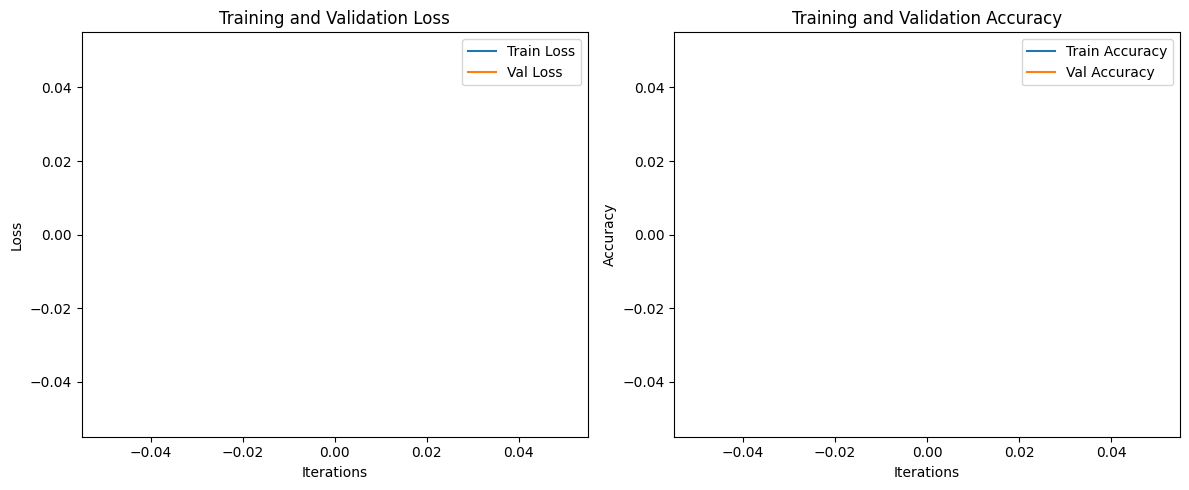

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 畫出 Loss 變化曲線
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot([i * len(train_loader) // 100 for i in range(len(val_losses))], val_losses, label='Val Loss') 
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 畫出準確率變化曲線
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot([i * len(train_loader) // 100 for i in range(len(val_accs))], val_accs, label='Val Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 題目 5：處理測試集並提交

在本題中，你需要讀取測試集，並使用模型分類出測試集中的每一條文本的情感。(5分）

In [205]:
import torch
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd

glove_model = KeyedVectors.load_word2vec_format("/kaggle/input/moai-2025-nlp-task/glove-wiki-gigaword-50.txt")
def text_to_vec_v2(text):
    # TODO: 題目 1.2
    vec=text.split(" ")    
    listh=np.zeros((3, 50))
    cnt=0
    for i in vec:
        i=i.lower()
        if i in glove_model:
            listt=glove_model[i]
            listh[cnt]=listt
            cnt+=1
            if cnt==3:break
    #print(listh)
    return np.array(listh)
df_test = pd.read_csv("/kaggle/input/moai-2025-nlp-task/test.csv")
listhh=np.zeros((24000,3, 50))
test_text = df_test['text'].values
for i in range(0,len(test_text)):
    listhh[i]=text_to_vec_v2(test_text[i])
    #print(new_text)
    #print(i)
test_embeddings=listhh

model.eval()
num2=torch.tensor(test_embeddings)
with torch.no_grad():
    # TODO: 使用模型生成輸出
    outputs = model(num2.to(device))
    predictions = outputs.argmax(dim=1)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [206]:
# predictions 應該是一個只包含分類輸出 (0,1,2,3,4,5) 的數組

print(predictions)

NameError: name 'predictions' is not defined

In [207]:
# 執行此代碼塊可以進行評分，請不要修改此代碼塊

task_grader.q5_check(predictions)

NameError: name 'predictions' is not defined

In [208]:
# 請不要修改此代碼塊

df_submission = pd.DataFrame({"label": predictions.cpu().numpy()})
df_submission.to_csv("submission.csv", index_label="id")

NameError: name 'predictions' is not defined

### 第一部分評分結果

以下代碼塊會輸出你在你第一部分題目的獲得分數

**注意：該結果僅供參考**

In [209]:
# 請不要修改此代碼塊

task_grader.print_final_scores()


=== 各小題得分 ===

[Q1] 文本向量化 (15分)
Q1.1 通過 (5/5分)
Q1.2 通過 (5/5分)
Q1.3 通過 (5/5分)
Q1 總分: 15/15分


[Q2] 數據預處理 (9分)
Q2.1 通過 (3/3分)
Q2.2 通過 (3/3分)
Q2.3 通過 (3/3分)
Q2 總分: 9/9分


[Q3] 模型設計 (8分)
Q3.1 通過 (2/2分)
Q3.2 通過 (2/2分)
Q3.3 未通過 (0/4分)
Q3 總分: 4/8分


[Q4] 訓練與評估 (8分)
Q4.1 通過 (3/3分)
Q4.2 未通過 (0/5分)
Q4 總分: 3/8分


[Q5] 預測結果 (5分)
Q5 未通過 (0/5分)

=== 最終總分 ===
總分: 31/45分


## 第二部分評分（55分)

你可以在 Notebook 右面的 Sidebar 中，點擊 Submit to competition -> Submit 來提交代碼，提交後可以在比賽頁面中的 Leaderboard 中看到測試集分類準確率（注意此分數僅作參考）。

提交結果的分類準確率，在賽後按照 `acc_to_score` 函數轉換為分數，滿分為 55 分（模型分類準確率 95% 或以上時滿分）。

以下代碼會畫出 `acc_to_score` 的形狀供參考

In [218]:
def acc_to_score(acc):
    if acc < 0 or acc > 100:
        raise ValueError("準確率應該在 0 - 100 之間")
        
    min_acc = 20
    max_acc = 95

    if acc < min_acc:
        return 0

    if acc > max_acc:
        return 55

    return np.round(55 * (acc - min_acc) ** 2 / (max_acc - min_acc) ** 2, 2)

In [219]:
# 你可以換成其他數字來計算分數

print(acc_to_score(90))

47.91


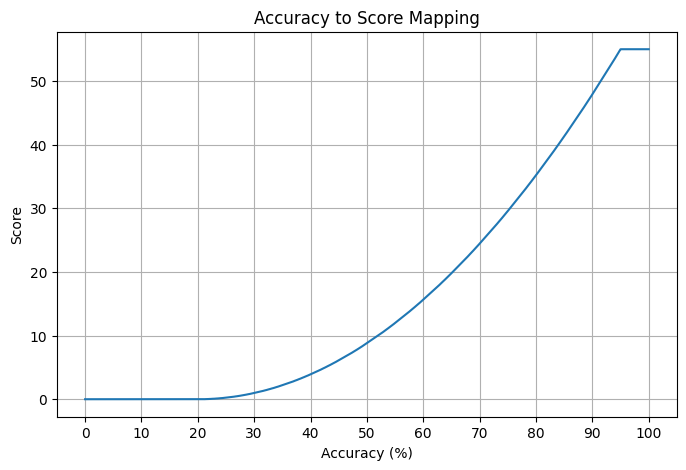

In [220]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))

acc = np.linspace(0, 100, 1000)
plt.plot(acc, [acc_to_score(a) for a in acc])

plt.title('Accuracy to Score Mapping')
plt.xlabel('Accuracy (%)')
plt.ylabel('Score')

plt.grid(True)
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 51, 10))

plt.show()

## 改善模型

在 grader 的所有測試通過後，你可以通過左上角的 File > Save Notebook 來保存當前的版本到本地，再使用 File -> New Notebook 來創建新的代碼，在新開的代碼中，你可以使用任何方法來改善模型的性能

最後提交的代碼有兩個版本，第一個版本是按是否通過 grader 來評分，第二個版本是按提交的 Kaggle 的分數來評分

## 最後提交

- 你最終提交到 google form 的應該是 2 個 `.ipynb` 文件，分別為
  - `NLP-part1.ipynb`，包含你第一版本（即按是否通過 grader 來評分）
  - `NLP-part2.ipynb`，包含你第二版本（即按 Kaggle 分數評分）